# Bayesian Tomatoes

<div class="banner-container">
<img src="http://content7.flixster.com/movie/11/16/81/11168101_det.jpg" width=180>
</div>

<div class="banner-container">
<img src="http://content6.flixster.com/movie/11/15/15/11151508_det.jpg" width=180>
</div>

<div class="banner-container">
<img src="http://content9.flixster.com/movie/11/16/61/11166199_det.jpg" width=180>
</div>

<div class="clear"> </div>

<style type="text/css">
.banner-container {
height:350px;
margin-left: 30px;
float:left;
}
.clear {
clear:both;
}
</style>

In this project, we'd be analsing the movie ratings from [Rotten Tomatoes](http://www.rottentomatoes.com). Categorically, we'd do the following tasks.

 * Making and interpreting predictions from a Bayesian perspective
 * Using the Naive Bayes algorithm to predict whether a movie review is positive or negative
 * Using cross validation to optimize models

In [2]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

from fnmatch import fnmatch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from pattern3 import web
import matplotlib as mpl
import bs4
from bs4 import BeautifulSoup
import matplotlib

# set some nicer defaults for matplotlib
from matplotlib import rcParams

#these colors come from colorbrewer2.org. Each is an RGB triplet
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.prop_cycle'] = matplotlib.cycler(color=dark2_colors)
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = True
rcParams['axes.facecolor'] = '#eeeeee'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

## Introduction

Rotten Tomatoes gathers movie reviews from critics. An [entry on the website](http://www.rottentomatoes.com/m/primer/reviews/?type=top_critics) typically consists of a short quote, a link to the full review, and a Fresh/Rotten classification which summarizes whether the critic liked/disliked the movie.


When critics give quantitative ratings (say 3/4 stars, Thumbs up, etc.), determining the Fresh/Rotten classification is easy. However, publications like the New York Times don't assign numerical ratings to movies, and thus the Fresh/Rotten classification must be inferred from the text of the review itself.

This basic task of categorizing text has many applications. All of the following questions boil down to text classification:

 * Is a movie review positive or negative?
 * Is an email spam, or not?
 * Is a comment on a blog discussion board appropriate, or not?
 * Is a tweet about your company positive, or not?
 

Language is incredibly nuanced, and there is an entire field of computer science dedicated to the topic (Natural Language Processing). Nevertheless, we can construct basic language models using fairly straightforward techniques. 

## The Data

The data to be used is already present in the file 'critics.csv'.

In [3]:
critics = pd.read_csv("critics.csv")

# dropping entries whose quotes are nan, whose value for fresh attribute is none
critics = critics[~critics.quote.isnull()]
critics = critics[critics.fresh != 'none']
critics = critics[critics.quote.str.len() > 0]
critics.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


### Exploratory Data Analysis

In [4]:
# count of number of critics
print("No. of Critics:",len(set(critics['critic'].values)))
print("No. of Reviews:",len(critics['quote']))
gb = critics.groupby('title')
print("No. of Movies:",len(gb.groups))

No. of Critics: 622
No. of Reviews: 15534
No. of Movies: 1921


In [5]:
critics.dtypes

critic         object
fresh          object
imdb            int64
publication    object
quote          object
review_date    object
rtid            int64
title          object
dtype: object

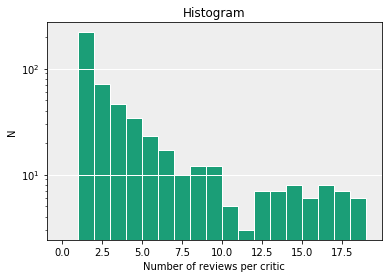

In [6]:
reviewers = critics.groupby('critic').rtid.count()
plt.title("Histogram")
reviewers.hist(log = True,bins = range(20), edgecolor='white')
plt.xlabel("Number of reviews per critic")
plt.ylabel("N")
plt.grid(False)
plt.grid(axis='y', color='w', linestyle='-', lw=1)

Top 5 reviewers who reviewed the most number of movies

In [7]:
reviewers2 = critics.groupby(['critic','publication']).rtid.count()
reviewers2.sort_values()[-1:-6:-1]

critic              publication      
Roger Ebert         Chicago Sun-Times    1072
James Berardinelli  ReelViews             804
Janet Maslin        New York Times        515
Variety Staff       Variety               429
Jonathan Rosenbaum  Chicago Reader        412
Name: rtid, dtype: int64

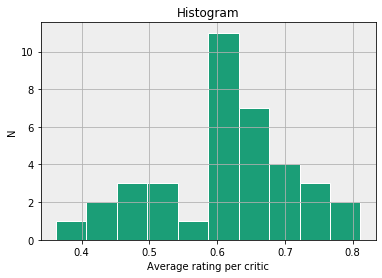

In [8]:
avg = {}
for name,grp in critics.groupby('critic')['fresh']:
    if(len(grp) > 100):
        avg[name] = ((grp == "fresh")*1).sum()/len(grp)
        
plt.title("Histogram")        
plt.hist([i for i in avg.values()],bins = 10,edgecolor = 'w')
plt.xlabel("Average rating per critic")
plt.ylabel("N")
plt.yticks([0, 2, 4, 6, 8, 10])
plt.show()

Here's a chunk of the MovieLens dataset.

## Sentiment Analysis

We will now use a [Naive Bayes classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) to build a prediction model for whether a review is fresh or rotten, depending on the text of the review.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print("Original text is\n", '\n'.join(text))

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print()
print("Transformed text vector is \n", x)

# `get_feature_names` tracks which word is associated with each column of the transformed x
print()
print("Words for each feature:")
print(vectorizer.get_feature_names())

# Notice that the bag of words treatment doesn't preserve information about the *order* of words, 
# just their frequency

Original text is
 Hop on pop
Hop off pop
Hop Hop hop

Transformed text vector is 
 [[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]

Words for each feature:
['hop', 'off', 'on', 'pop']


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

"""
Function
--------
make_xy

Build a bag-of-words training set for the review data

Parameters
-----------
critics : Pandas DataFrame
    The review data from above
    
vectorizer : CountVectorizer object (optional)
    A CountVectorizer object to use. If None,
    then create and fit a new CountVectorizer.
    Otherwise, re-fit the provided CountVectorizer
    using the critics data
    
Returns
-------
X : numpy array (dims: nreview, nwords)
    Bag-of-words representation for each review.
Y : numpy array (dims: nreview)
    1/0 array. 1 = fresh review, 0 = rotten review

Examples
--------
X, Y = make_xy(critics)
"""

def make_xy(critics,vectorizer=None):
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics['quote'])
    X = X.tocsc()
    Y = (critics['fresh'] == 'fresh')*1
    return X,Y

In [11]:
X, Y = make_xy(critics)

Next, we'd randomly split the data into two groups: a
training set and a validation set. 

We'd use the training set to train a `MultinomialNB` classifier,
and print the accuracy of this model on the validation set.

In [12]:
Xtrain,Xtest,ytrain,ytest = train_test_split(X,Y)
clf = MultinomialNB().fit(Xtrain, ytrain)
print("Accuracy: %0.2f%%" % (100 * clf.score(Xtest, ytest)))

Accuracy: 76.65%


We say a model is **overfit** if it performs better on the training data than on the test data.

In [13]:
train_accuracy = clf.score(Xtrain,ytrain)
test_accuracy = clf.score(Xtest,ytest)

print("Training Accuracy: %0.2f%%" % (100*train_accuracy))
print("Testing Accuracy: %0.2f%%" % (100*test_accuracy))

Training Accuracy: 92.22%
Testing Accuracy: 76.65%


*Some overfitting seems to be happening here, since the error rate on the test data (23%) is more than twice as large as the error rate on the training data (10%). It's possible (though unlikely) that the accuracy difference is a product of chance, and not a symptom of overfitting. This could be tested with cross-validation, by repeatedly fitting and scoring the classifier on different train/test splits. If the performance on the training data is consistently better than the test data, then overfitting has occured. This is the case here.*

Bayesian models like the Naive Bayes classifier have the nice property that they compute probabilities of a particular classification. 

Thus we'd assess whether these probabilities are **calibrated** -- that is, whether a prediction made with a confidence of `x%` is correct approximately `x%` of the time. We care about calibration because it tells us whether we can trust the probabilities computed by a model. If we can trust model probabilities, we can make better decisions using them (for example, we can calculate how much we should bet or invest in a given prediction).

In [14]:
"""
Function
--------
calibration_plot

Build a calibration plot from a classifier and review data

Inputs
-------
clf : Classifier object
    A MultinomialNB classifier
X : (Nexample, Nfeature) array
    The bag-of-words data
Y : (Nexample) integer array
    1 if a review is Fresh
"""
def calibration_plot(clf,X,Y):
    bins = [[] for i in range(20)]
    prob = clf.predict_proba(X)[:,1]
    for i in range(len(prob)):
        bins[int((prob[i]*100)/5)].append((i,prob[i]))
    # [len(i) for i in bins]
    # def caliberation_plot(clf,X,Y):
    counts = []
    fractions = []
    uncrt = []
    for i in range(20):
        fresh = 0
        counts.append(len(bins[i]))
        for j in range(len(bins[i])):
            if(Y.values[bins[i][j][0]] == 1):
                fresh += 1
        fractions.append(fresh/counts[i])
        uncrt.append(np.sqrt(fractions[i]*(1-fractions[i])/counts[i]))
    ax = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    plt.errorbar([i/100 for i in range(0,100,5)],fractions,uncrt)
    plt.plot([i for i in range(0,2)], [i for i in range(0,2)], linestyle='--', lw=1, color='k')
    plt.ylabel("Empirical P(Fresh)")
    ax = plt.subplot2grid((3, 1), (2, 0), sharex=ax,rowspan=4)
    plt.bar([i/100 for i in range(0,100,5)],counts,width = 0.05,edgecolor='white')
    plt.xlabel("Predicted P(Fresh)")
    plt.ylabel("Number")
    plt.show()

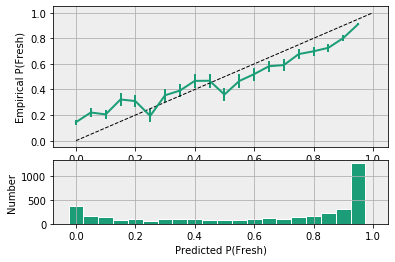

In [15]:
calibration_plot(clf, Xtest, ytest)

We might say a model is *over-confident* if the freshness fraction is usually closer to 0.5 than expected (that is, there is more uncertainty than the model predicted). Likewise, a model is *under-confident* if the probabilities are usually further away from 0.5.

This model is over-confident. For a properly calibrated model, we would expect ~10% of the P(Fresh)~0.1 reviews to actually be fresh. However, the actual freshness rate is closer to 30%. Likewise, for reviews where P(Fresh) ~0.9, the actuall freshness fraction is closer to 0.7. In other words, there is more uncertainty in the outcome than implied by the model.

#### Validation

Our classifier has a few free parameters. The two most important are:

 1. The `min_df` keyword in `CountVectorizer`, which will ignore words which appear in fewer than `min_df` fraction of reviews. Words that appear only once or twice can lead to overfitting, since words which occur only a few times might correlate very well with Fresh/Rotten reviews by chance in the training dataset.
 
 2. The [`alpha` keyword](http://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes) in the Bayesian classifier is a "smoothing parameter" -- increasing the value decreases the sensitivity to any single feature, and tends to pull prediction probabilities closer to 50%.

In [77]:
"""
Function
--------
log_likelihood

Compute the log likelihood of a dataset according to a bayesian classifier. 
The Log Likelihood is defined by

L = Sum_fresh(logP(fresh)) + Sum_rotten(logP(rotten))

Where Sum_fresh indicates a sum over all fresh reviews, 
and Sum_rotten indicates a sum over rotten reviews
    
Parameters
----------
clf : Bayesian classifier
x : (nexample, nfeature) array
    The input data
y : (nexample) integer array
    Whether each review is Fresh
"""

def log_likelihood(clf,x,y):
    res = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return res[rotten, 0].sum() + res[fresh, 1].sum()

In [57]:
from sklearn.model_selection import KFold

def cv_score(clf, x, y, score_func):
    """
    Uses 5-fold cross validation to estimate a score of a classifier
    
    Inputs
    ------
    clf : Classifier object
    x : Input feature vector
    y : Input class labels
    score_func : Function like log_likelihood, that takes (clf, x, y) as input,
                 and returns a score
                 
    Returns
    -------
    The average score obtained by randomly splitting (x, y) into training and 
    test sets, fitting on the training set, and evaluating score_func on the test set
    
    Examples
    cv_score(clf, x, y, log_likelihood)
    """
    result = 0
    nfold = 5
    clf.fit(x,y)
    kf = KFold(n_splits = nfold)
    for train, test in kf.split(x): # split data into train/test groups, 5 times
        #print(train,test)
        #np.nan_to_num(x[train])
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf, x[test], y[test]) # evaluate score function on held-out data
    return result / nfold

In [79]:
#the grid of parameters to search over
from sklearn.model_selection import KFold

alphas = [1e-10, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
max_loglike = -np.inf
kf = KFold(5)
for alpha in alphas:
    for min_df in min_dfs:         
        vectorizer = CountVectorizer(min_df = min_df)       
        X, Y = make_xy(critics, vectorizer)
        clf = MultinomialNB(alpha=alpha)
        err = 0
        Xtrain,Xtest,ytrain,ytest = train_test_split(X,Y)
        clf.fit(Xtrain,ytrain)
        s = log_likelihood(clf,Xtest,ytest)
        if(s>max_loglike):
            max_loglike = s
            best_alpha = alpha
            best_min_df = min_df

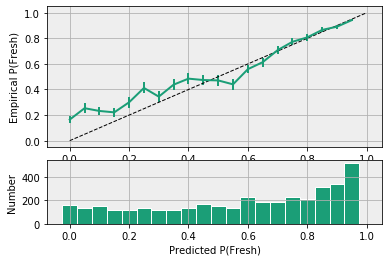

Accuracy on training data: 0.79
Accuracy on test data:     0.73


In [114]:
vectorizer = CountVectorizer(min_df=0.001)
X, Y = make_xy(critics, vectorizer)
xtrain, xtest, ytrain, ytest = train_test_split(X, Y)

clf = MultinomialNB(alpha=5.0).fit(xtrain, ytrain)

calibration_plot(clf, xtest, ytest)

# Your code here. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: %0.2f" % (training_accuracy))
print("Accuracy on test data:     %0.2f" % (test_accuracy))

*The new model is slightly less accurate on the test data (73% vs 76.65% on the original model). However, it is both better calibrated and less over-fit than before. In other words, while the classification accuracy is slightly worse, the probabilities themselves are more accurate. The model is still slightly over-confident when making low P(Fresh) predictions. However, the calibration plot shows the model is usually within 1 error bar of the expected performance where P(Fresh) >= 0.2. Finally, the new model makes less-conclusive predictions on average -- the histogram in the calibration plot is more uniformly distributed, with fewer predictions clustered around P(Fresh) = 0 or 1.*

### Interpretation

In [115]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("%20s" % w, "%0.2f" % (1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("%20s" % w, "%0.2f" % (1 - np.exp(p)))

Good words	     P(fresh | word)
         masterpiece 0.90
            touching 0.90
             delight 0.90
          remarkable 0.88
               smart 0.87
               witty 0.87
              moving 0.86
         intelligent 0.86
              superb 0.86
        entertaining 0.86
Bad words	     P(fresh | word)
       disappointing 0.22
               bland 0.21
      disappointment 0.20
           pointless 0.19
                dull 0.19
            tiresome 0.18
          uninspired 0.18
             unfunny 0.18
                lame 0.15
       unfortunately 0.14


In [116]:
x,y = make_xy(critics,vectorizer)
prob = clf.predict_proba(x)[:,0]
predict = clf.predict(x)

bad_fresh = np.argsort(prob[(y == 1)])[-5:]
for i in bad_fresh:
    print(critics.iloc[i].quote)
    print()
bad_rotten = np.argsort(prob[(y==0)])[:5]
for i in bad_rotten:
    print(critics.iloc[i].quote)
    print()

A thoroughly mediocre action movie.

Though it doesn't exactly bowl you over with its ambitions, this teensy but breezy sleeper can at least be mentioned in a breath with two memorable predecessors it recalls ... Breakfast at Tiffany's.

A disappointment for anyone hoping the studio would raise the standard of the animated feature to a new level.

Good macabre fun.

Escape from L.A. is too preposterous to be a good film. But in keeping with its title, it does provide a couple of hours of entertaining escapism.

While Leone's vision still has a magnificent sweep, the film finally subsides to an emotional core that is sombre, even elegiac, and which centres on a man who is bent and broken by time, and finally left with nothing but an impotent sadness.

The filmmakers seem to think of their movie as a fiduciary fable, but they're not quite sure about its moral.

Together, these characters discover the ideas of faith and fellowship as the film congratulates itself on its noble instincts.



In [122]:
x,y = make_xy(critics,vectorizer)
prob = clf.predict_proba(x)[:,0]
predict = clf.predict(x)

bad_fresh = np.argsort(prob[(y == 1)])[-5:]
print("Mispredicted Fresh quotes")
print("==========================")
for i in bad_fresh:
    print(critics.iloc[i].quote)
    print()

print("Mispredicted Rotten quotes")
print("==========================")
bad_rotten = np.argsort(prob[(y==0)])[:5]
for i in bad_rotten:
    print(critics.iloc[i].quote)
    print()

Mispredicted Fresh quotes
A thoroughly mediocre action movie.

Though it doesn't exactly bowl you over with its ambitions, this teensy but breezy sleeper can at least be mentioned in a breath with two memorable predecessors it recalls ... Breakfast at Tiffany's.

A disappointment for anyone hoping the studio would raise the standard of the animated feature to a new level.

Good macabre fun.

Escape from L.A. is too preposterous to be a good film. But in keeping with its title, it does provide a couple of hours of entertaining escapism.

Mispredicted Rotten quotes
While Leone's vision still has a magnificent sweep, the film finally subsides to an emotional core that is sombre, even elegiac, and which centres on a man who is bent and broken by time, and finally left with nothing but an impotent sadness.

The filmmakers seem to think of their movie as a fiduciary fable, but they're not quite sure about its moral.

Together, these characters discover the ideas of faith and fellowship as th

In [123]:
clf.predict_proba(vectorizer.transform(['This movie is not remarkable, touching, or superb in any way']))

array([[0.00913994, 0.99086006]])

*Many mis-predictions seem due to the fact that the quotes use more ambivalent language -- quotes along the lines of "this should have been a good movie, but it wasn't". Words like "but", "not", etc. act to negate the sentiment of words. However, because Naive Bayes treats each word separately, it isn't able to capture these kind of word interactions. Because the quote "this movie is not remarkable, touching, or superb in any way" contains typically positive words like remarkabke/touching/superb, the classifier gives it P(Fresh)=0.98.*

Lastly, there are things worth trying in order to improve. Some examples:

1. We could try to build a NB model where the features are word pairs instead of words. This would be smart enough to realize that "not good" and "so good" mean very different things. This technique doesn't scale very well, since these features are much more sparse (and hence harder to detect repeatable patterns within).
2. We could consider adding supplemental features -- information about genre, director, cast, etc.